In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
data = np.load("../../Data/development.npy")
data_csv = pd.read_csv("../../Data/metadata/development.csv")
idx_to_feature_name = pd.read_csv("../../Data/metadata/idx_to_feature_name.csv")

In [3]:
labels = data_csv['word']
y = {}
labels_new = []
i = 0
for label in np.unique(labels).tolist():
    if label == 'other':
        continue
    else:
        y[label] = i
        i += 1
for label in labels:
    if label == 'other':
        continue
    else:
        labels_new.append(y[label])

In [4]:
data_no_other = data[:40834, :, :]

In [26]:
y

{'Alarm': 0,
 'Brötchen': 1,
 'Fernseher': 2,
 'Haus': 3,
 'Heizung': 4,
 'Leitung': 5,
 'Licht': 6,
 'Lüftung': 7,
 'Ofen': 8,
 'Radio': 9,
 'Schraube': 10,
 'Spiegel': 11,
 'Staubsauger': 12,
 'an': 13,
 'aus': 14,
 'kann': 15,
 'nicht': 16,
 'offen': 17,
 'warm': 18,
 'wunderbar': 19}

In [38]:
#data_new = np.concatenate((data[:, :11, :], data[:, 171:, :]), axis=1)
#data_test = np.concatenate((data[:4, :11, :], data[:4, 76:, :]), axis=1)
#data_train = np.concatenate((data_no_other[:36236, :22, :], data_no_other[:36236, 87:, :]), axis=1) # data[samples, features, ...]
#data_valid = np.concatenate((data_no_other[36236:, :22, :], data_no_other[36236:, 87:, :]), axis=1)
#data_train = data[:36236, :, :]
#data_valid = data[36236:, :, :] 32667

data_train = np.concatenate((data_no_other[:32667, :22, :], data_no_other[:32667, 87:, :]), axis=1) # data[samples, features, ...]
data_valid = np.concatenate((data_no_other[32667:, :22, :], data_no_other[32667:, 87:, :]), axis=1)
print(data_train.shape, data_valid.shape)

(32667, 110, 44) (8167, 110, 44)


In [6]:
data_train = data_no_other[:32667, :, :]
data_valid = data_no_other[32667:, :, :]
labels_train = labels_new[:32667]
labels_valid = labels_new[32667:]
print(data_train.shape, data_valid.shape)

(32667, 175, 44) (8167, 175, 44)


In [7]:
X_tensor_train = torch.tensor(data_train, dtype=torch.float32)
y_tensor_train = torch.tensor(labels_train, dtype=torch.long)
X_tensor_valid = torch.tensor(data_valid, dtype=torch.float32)
y_tensor_valid = torch.tensor(labels_valid, dtype=torch.long)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [9]:
from model_architectures import EnhancedAudioCNN

In [10]:
model = EnhancedAudioCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

dataset_train = CustomDataset(X_tensor_train, y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, drop_last=True)

dataset_valid = CustomDataset(X_tensor_valid, y_tensor_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=False, drop_last=True)

use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

model.to(device)

EnhancedAudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=32, out_features=20, bias=True)
)

In [11]:
# Example training loop
num_epochs = 20
#total_iterations = num_epochs * (len(dataloader_train) + len(dataloader_valid))
#progress_bar = tqdm(total=total_iterations, desc='Training and Evaluation')

losses_train = []
losses_valid = []

for epoch in range(num_epochs):
    model.train()
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        features = features.unsqueeze(1)
        inputs = features.to(device)
        targets = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    losses_train.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        for features, labels in dataloader_valid:
            inputs = features.to(device)
            inputs = inputs.unsqueeze(1)
            targets = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        losses_valid.append(loss.item())
    if losses_train[-1] < 0.3 and losses_valid[-1] < 0.2:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_epoch_{epoch}.pth')
    #progress_bar.update(2)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training loss: {losses_train[-1]}, Validation loss: {losses_valid[-1]}')

Epoch 1/20, Training loss: 1.221971035003662, Validation loss: 0.9578855037689209
Epoch 2/20, Training loss: 1.0638556480407715, Validation loss: 0.644181489944458
Epoch 3/20, Training loss: 1.0396398305892944, Validation loss: 0.9693616628646851
Epoch 4/20, Training loss: 0.5016836524009705, Validation loss: 0.6327088475227356
Epoch 5/20, Training loss: 0.508704662322998, Validation loss: 1.0011146068572998
Epoch 6/20, Training loss: 0.7566627860069275, Validation loss: 0.2394142746925354
Epoch 7/20, Training loss: 0.26752936840057373, Validation loss: 0.2465195506811142
Epoch 8/20, Training loss: 0.3398037254810333, Validation loss: 0.3723073899745941
Epoch 9/20, Training loss: 0.1981135606765747, Validation loss: 0.2288767695426941
Epoch 10/20, Training loss: 0.477830708026886, Validation loss: 0.3052626848220825
Epoch 11/20, Training loss: 0.20465168356895447, Validation loss: 0.16063320636749268
Epoch 12/20, Training loss: 0.30762097239494324, Validation loss: 0.3527524769306183
E

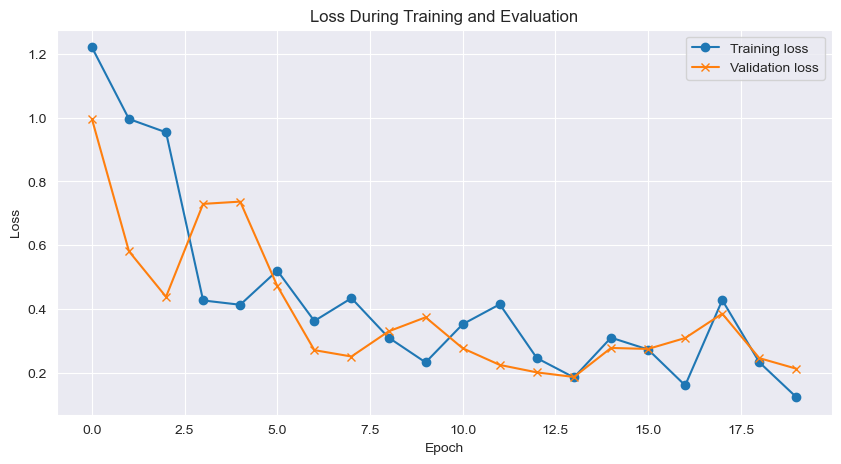

In [46]:
import matplotlib.pyplot as plt

# Assuming 'losses' is a list of float numbers representing the loss values
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(losses_train, label='Training loss', marker='o')
plt.plot(losses_valid, label='Validation loss', marker='x')  # Plot the losses with line and markers
plt.title('Loss During Training and Evaluation')  # Give the plot a title
plt.xlabel('Epoch')  # Label the x-axis as 'Epoch'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.grid(True)  # Enable grid for easier readability
plt.legend()
plt.show()  # Display the plot

In [48]:
losses = {}
i = 0
for train, valid in zip(losses_train, losses_valid):
    losses[i] = (train + valid) / 2.0
    i += 1
print(losses)

{0: 1.0238907933235168, 1: 0.7726849913597107, 2: 0.41017571091651917, 3: 0.5054782330989838, 4: 0.4352187514305115, 5: 0.5672700107097626, 6: 0.7523325383663177, 7: 0.264121949672699, 8: 0.3519875258207321, 9: 0.5537025630474091, 10: 0.30785714089870453, 11: 0.20711658895015717, 12: 0.24715276062488556, 13: 0.2825005501508713, 14: 0.26964741945266724, 15: 0.6623668819665909, 16: 0.42854635417461395, 17: 0.24534934759140015, 18: 0.3023391216993332, 19: 0.19091109931468964}
